In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option("display.precision", 4)

from modules.helpers import parseMatrixRows, parseMatrixColumns, parseMatrixIndexes
from modules.plot import highlightNotZero

from modules.model import BarProps, Point, Bar
from modules.matrices import LoadMatrix, BarMatrices, modelMatrix
from modules.internalForces import *

## Vstupy

In [2]:
crossSection = {"width": 200, "height": 300}
material = "C30/37"
barProps = BarProps(material, crossSection)
print(f'E = {barProps.E} kPa \nI = {barProps.I} m-4\nA = {barProps.A} m2')

E = 33000000.0 kPa 
I = 0.00044999999999999993 m-4
A = 0.06 m2


Sily

In [3]:
F = 40 #kN
Q = 5 #kN/m
load_bar12 = Load(Q = Q)
load_bar23 = Load(F = F, F_position=0.5)
load_bar34 = Load(Q=0, F=0)

Definovanie bodov

In [4]:
p1 = Point(0,0)
p2 = Point(0,3)
p3 = Point(3,3)
p4 = Point(3,0)

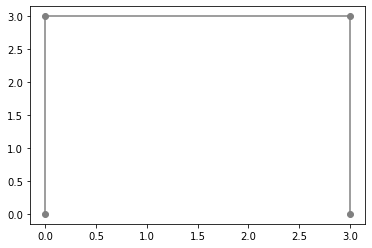

In [5]:
y = np.array([p1.y,p2.y,p3.y,p4.y])
x = np.array([p1.x,p2.x,p3.x,p4.x])
plt.plot(x,y, 'o-', color='gray')

Podpery

In [6]:
p1.stiff #votknutie v bode 1
p4.hinge #klbova podpera v bode 4
print(p1,"\n",p2,"\n",p3,"\n",p4)


Point(x=0, y=0, dof=[0, 0, 0]) 
 Point(x=0, y=3, dof=[1, 1, 1]) 
 Point(x=3, y=3, dof=[1, 1, 1]) 
 Point(x=3, y=0, dof=[0, 0, 1])


Definovanie prútov

In [7]:
bar12 = Bar(p1, p2)
bar23 = Bar(p2, p3)
bar34 = Bar(p3, p4)
print(f'bar12 = {bar12.len} m \nbar23 = {bar23.len} m\nbar34 = {bar34.len} m')

bar12 = 3.0 m 
bar23 = 3.0 m
bar34 = 3.0 m


## Vzorové riešenie na prúte 1-2

### Matica tuhosti v LSS

In [8]:
bar12_matrices = BarMatrices(barProps, bar12)
k12 = bar12_matrices.lss_stiffness
k12

,0,1,2
0,660000.0,0.0,0.0
1,0.0,6600.0,9900.0
2,0.0,9900.0,19800.0


### Matica rotácie

Uhol rotácie

In [9]:
alfa_1 = bar12.angle
print(f'alfa = {alfa_1} deg')

alfa = -90.0 deg


Matica

In [10]:
A0_1 = bar12_matrices.rotation
A0_1

,0,1,2
0,6.1232e-17,-1.0000e+00,0
1,1.0000e+00,6.1232e-17,0
2,0.0000e+00,0.0000e+00,1


### Prenosová matica

Posun

In [11]:
[lx, ly] = bar12.l_xy
print(f'lx = {lx}\nly = {ly}')

lx = 0
ly = -3


Matica

In [12]:
B0_1 = bar12_matrices.transmission
B0_1

,0,1,2
0,-1,0,0
1,0,-1,0
2,3,0,-1


### Matica tuhosti v GSS

In [13]:
k1 = bar12_matrices.gss_stiffness
k1 = parseMatrixIndexes(k1, [0,1,2,3,4,5])
k1

,0,1,2,3,4,5
0,6.6000e+03,-4.0009e-11,9.9000e+03,-6.6000e+03,4.0009e-11,9.9000e+03
1,-4.0009e-11,6.6000e+05,6.0620e-13,4.0009e-11,-6.6000e+05,-1.2063e-10
2,9.9000e+03,6.0620e-13,1.9800e+04,-9.9000e+03,-6.0620e-13,9.9000e+03
3,-6.6000e+03,4.0009e-11,-9.9000e+03,6.6000e+03,-4.0009e-11,-9.9000e+03
4,4.0009e-11,-6.6000e+05,-6.0620e-13,-4.0009e-11,6.6000e+05,1.2063e-10
5,9.9000e+03,-1.2063e-10,9.9000e+03,-9.9000e+03,1.2063e-10,1.9800e+04


### Primárne vnútorné sily

Vnútorné sily - *Bod 1*

In [14]:
IntF_12 = InternalForces_primary(load_bar12, bar12)

In [15]:
IntF_12 = InternalForces_primary(load_bar12, bar12)
print(f'N_12 = {0} kN\nV_12 = {IntF_12.Va} kN\nM_12 = {IntF_12.Ma} kNm')

N_12 = 0 kN
V_12 = -7.5 kN
M_12 = -3.75 kNm


Vnútorné sily - *Bod 2*

In [16]:
print(f'N_21 = {0} kN\nV_21 = {IntF_12.Vb} kN\nM_21 = {IntF_12.Mb} kNm')

N_21 = 0 kN
V_21 = -7.5 kN
M_21 = 3.75 kNm


Silový vektor v LSS - *Bod 1*

In [17]:
F12_l = LoadMatrix.lss(0, IntF_12.Va, IntF_12.Ma)
F12_l

,0
0,0.00
1,-7.50
2,-3.75


Silový vektor v LSS - *Bod 2*

In [18]:
F21_l = LoadMatrix.lss(0, IntF_12.Vb, IntF_12.Mb)
F21_l

,0
0,0.00
1,-7.50
2,3.75


Vnutorne sily v bode 2

Silový vektor v GSS pre celý prút

In [19]:
F12_g = LoadMatrix.gss(F12_l, A0_1.T)
F21_g = LoadMatrix.gss(F21_l, A0_1.T)

F1 = LoadMatrix.super(F12_g, F21_g)
F1 = parseMatrixRows(F1,[0,1,2,3,4,5])
F1

,0
0,-7.5000e+00
1,-4.5924e-16
2,-3.7500e+00
3,-7.5000e+00
4,-4.5924e-16
5,3.7500e+00


## Riešenie na prúte 2-3

In [20]:
[lx,ly] = bar23.l_xy
alfa_2 = bar23.angle
print(f'alfa = {alfa_2} deg')
print(f'lx = {lx}\nly = {ly}')

alfa = 0.0 deg
lx = 3
ly = 0


In [21]:
bar23_matrices = BarMatrices(barProps, bar23)
k23 = bar23_matrices.lss_stiffness
A0_2 = bar23_matrices.rotation
B0_2 = bar23_matrices.transmission
k2 = bar23_matrices.gss_stiffness
k2 = parseMatrixIndexes(k2,[3,4,5,6,7,8])
k2

,3,4,5,6,7,8
3,660000.0,0.0,0.0,-660000.0,0.0,0.0
4,0.0,6600.0,9900.0,0.0,-6600.0,9900.0
5,0.0,9900.0,19800.0,0.0,-9900.0,9900.0
6,-660000.0,0.0,0.0,660000.0,0.0,0.0
7,0.0,-6600.0,-9900.0,0.0,6600.0,-9900.0
8,0.0,9900.0,9900.0,0.0,-9900.0,19800.0


In [22]:
IntF_23 = InternalForces_primary(load_bar23, bar23)

In [23]:
F23_l = LoadMatrix.lss(0, IntF_23.Va, IntF_23.Ma)
F32_l = LoadMatrix.lss(0, IntF_23.Vb, IntF_23.Mb)
F23_g = LoadMatrix.gss(F23_l, A0_2.T)
F32_g = LoadMatrix.gss(F32_l, A0_2.T)

F2 = LoadMatrix.super(F23_g, F32_g)
F2 = parseMatrixRows(F2,[3,4,5,6,7,8])
F2

,0
3,0.0
4,-20.0
5,-15.0
6,0.0
7,-20.0
8,15.0


## Riešenie na prúte 3-4

In [24]:
[lx, ly] = bar34.l_xy
alfa_3 = bar34.angle
print(f'alfa = {alfa_3} deg')
print(f'lx = {lx}\nly = {ly}')

alfa = 90.0 deg
lx = 0
ly = 3


In [25]:
bar34_matrices = BarMatrices(barProps, bar34)
k34 = bar34_matrices.lss_stiffness
A0_3 = bar23_matrices.rotation
B0_3 = bar23_matrices.transmission
k3 = bar34_matrices.gss_stiffness
k3 = parseMatrixIndexes(k3,[6,7,8,9,10,11])
k3

,6,7,8,9,10,11
6,6.6000e+03,4.0009e-11,-9.9000e+03,-6.6000e+03,-4.0009e-11,-9.9000e+03
7,4.0009e-11,6.6000e+05,6.0620e-13,-4.0009e-11,-6.6000e+05,-1.2063e-10
8,-9.9000e+03,6.0620e-13,1.9800e+04,9.9000e+03,-6.0620e-13,9.9000e+03
9,-6.6000e+03,-4.0009e-11,9.9000e+03,6.6000e+03,4.0009e-11,9.9000e+03
10,-4.0009e-11,-6.6000e+05,-6.0620e-13,4.0009e-11,6.6000e+05,1.2063e-10
11,-9.9000e+03,-1.2063e-10,9.9000e+03,9.9000e+03,1.2063e-10,1.9800e+04


In [26]:
IntF_34 = InternalForces_primary(load_bar34, bar34)

In [27]:
F34_l = LoadMatrix.lss(0, IntF_34.Va, IntF_34.Ma)
F43_l = LoadMatrix.lss(0, IntF_34.Vb, IntF_34.Mb)
F34_g = LoadMatrix.gss(F34_l, A0_3.T)
F43_g = LoadMatrix.gss(F43_l, A0_3.T)

F3 = LoadMatrix.super(F34_g, F43_g)
F3 = parseMatrixRows(F3,[6,7,8,9,10,11])
F3

,0
6,0.0
7,0.0
8,0.0
9,0.0
10,0.0
11,0.0


## Matica tuhosti celého rámu

Matica tuhosti bez zohľadnenia okrajových podmienok

In [28]:
modelMatrix = modelMatrix([k1,k2,k3])
modelMatrix.style\
.format('{:.2e}')\
.applymap(highlightNotZero)

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.60e+03,-4.00e-11,9.90e+03,-6.60e+03,4.00e-11,9.90e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,-4.00e-11,6.60e+05,6.06e-13,4.00e-11,-6.60e+05,-1.21e-10,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
2,9.90e+03,6.06e-13,1.98e+04,-9.90e+03,-6.06e-13,9.90e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
3,-6.60e+03,4.00e-11,-9.90e+03,6.67e+05,-4.00e-11,-9.90e+03,-6.60e+05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
4,4.00e-11,-6.60e+05,-6.06e-13,-4.00e-11,6.67e+05,9.90e+03,0.00e+00,-6.60e+03,9.90e+03,0.00e+00,0.00e+00,0.00e+00
5,9.90e+03,-1.21e-10,9.90e+03,-9.90e+03,9.90e+03,3.96e+04,0.00e+00,-9.90e+03,9.90e+03,0.00e+00,0.00e+00,0.00e+00
6,0.00e+00,0.00e+00,0.00e+00,-6.60e+05,0.00e+00,0.00e+00,6.67e+05,4.00e-11,-9.90e+03,-6.60e+03,-4.00e-11,-9.90e+03
7,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-6.60e+03,-9.90e+03,4.00e-11,6.67e+05,-9.90e+03,-4.00e-11,-6.60e+05,-1.21e-10
8,0.00e+00,0.00e+00,0.00e+00,0.00e+00,9.90e+03,9.90e+03,-9.90e+03,-9.90e+03,3.96e+04,9.90e+03,-6.06e-13,9.90e+03
9,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-6.60e+03,-4.00e-11,9.90e+03,6.60e+03,4.00e-11,9.90e+03


## Matica tuhosti zohľadňujúca okrajové podmienky

In [29]:
def boundaryConditionsVector(points: list) -> list:
    dofList=[]
    for point in points:
        dofList.append(point.dof)
    return pd.DataFrame(np.array(dofList).flatten())
    
def boundaryConditionsFilter(bc_vector, cond):
    bc = np.array(bc_vector).flatten()
    df = pd.DataFrame(bc)
    return df[df[0]==cond].index.values.astype(int)

def loadVector(F1,F2,F3):
    x = F1.add(F2,fill_value=0)
    return x.add(F3,fill_value=0)


Silový vektor celého rámu

In [30]:
loadVector = loadVector(F1,F2,F3)
loadVector

,0
0,-7.5000e+00
1,-4.5924e-16
2,-3.7500e+00
3,-7.5000e+00
4,-2.0000e+01
5,-1.1250e+01
6,0.0000e+00
7,-2.0000e+01
8,1.5000e+01
9,0.0000e+00


In [31]:
bc_vector = boundaryConditionsVector([p1,p2,p3,p4])

Silový vektor po zohľadnení okrajových podmienok

In [32]:
bc_0 = boundaryConditionsFilter(bc_vector, 0)
loadVector.drop(bc_0, inplace=True)
loadVector

,0
3,-7.50
4,-20.00
5,-11.25
6,0.00
7,-20.00
8,15.00
11,0.00


Matica tuhosti po zohľadnení okrajových podmienok

In [33]:
bc_1 = boundaryConditionsFilter(bc_vector, 1)
copyModelMatrix = modelMatrix.copy()
copyModelMatrix.drop(bc_0, inplace=True)
filteredModelMatrix = copyModelMatrix[bc_1]
parseMatrixIndexes(filteredModelMatrix.copy(), ["u[2]", "v[2]", "fi[2]","u[3]", "v[3]", "fi[3]","fi[4]"])

,u[2],v[2],fi[2],u[3],v[3],fi[3],fi[4]
u[2],6.6660e+05,-4.0009e-11,-9900.0,-6.6000e+05,0.0000e+00,0.0,0.0000e+00
v[2],-4.0009e-11,6.6660e+05,9900.0,0.0000e+00,-6.6000e+03,9900.0,0.0000e+00
fi[2],-9.9000e+03,9.9000e+03,39600.0,0.0000e+00,-9.9000e+03,9900.0,0.0000e+00
u[3],-6.6000e+05,0.0000e+00,0.0,6.6660e+05,4.0009e-11,-9900.0,-9.9000e+03
v[3],0.0000e+00,-6.6000e+03,-9900.0,4.0009e-11,6.6660e+05,-9900.0,-1.2063e-10
fi[3],0.0000e+00,9.9000e+03,9900.0,-9.9000e+03,-9.9000e+03,39600.0,9.9000e+03
fi[4],0.0000e+00,0.0000e+00,0.0,-9.9000e+03,-1.2063e-10,9900.0,1.9800e+04


## Deformácie

Inverzná matica tuhosti

In [34]:
inv = pd.DataFrame(np.linalg.inv(filteredModelMatrix.values), filteredModelMatrix.columns, filteredModelMatrix.index)
inv

,3,4,5,6,7,8,11
3,1.8004e-04,-8.2434e-07,4.1878e-05,1.7970e-04,8.2434e-07,1.4177e-05,8.2760e-05
4,-8.2434e-07,1.5134e-06,-4.8091e-07,-8.2537e-07,1.7172e-09,-4.1243e-07,-2.0647e-07
5,4.1878e-05,-4.8091e-07,3.7049e-05,4.1741e-05,4.8091e-07,-4.3477e-06,2.3044e-05
6,1.7970e-04,-8.2537e-07,4.1741e-05,1.8087e-04,8.2537e-07,1.4384e-05,8.3242e-05
7,8.2434e-07,1.7172e-09,4.8091e-07,8.2537e-07,1.5134e-06,4.1243e-07,2.0647e-07
8,1.4177e-05,-4.1243e-07,-4.3477e-06,1.4384e-05,4.1243e-07,3.2393e-05,-9.0044e-06
11,8.2760e-05,-2.0647e-07,2.3044e-05,8.3242e-05,2.0647e-07,-9.0044e-06,9.6628e-05


In [35]:
displacements = inv.dot(loadVector)*-1
parseMatrixRows(displacements.copy(), ["u[2]", "v[2]", "fi[2]","u[3]", "v[3]", "fi[3]","fi[4]"])

,0
u[2],1.6088e-03
v[2],2.4897e-05
fi[2],7.9611e-04
u[3],1.6016e-03
v[3],3.5709e-05
fi[3],-4.2848e-04
fi[4],1.0150e-03


In [36]:
def modelDisplacements(displacements):
     return pd.DataFrame(np.zeros((12, 1))).add(displacements, fill_value=0)

In [37]:
modelDisplacements = modelDisplacements(displacements)
rows = ["u[1]", "v[1]", "fi[1]","u[2]", "v[2]", "fi[2]","u[3]", "v[3]", "fi[3]","u[4]", "v[4]", "fi[4]"]
parseMatrixRows(modelDisplacements.copy(), rows)

,0
u[1],0.0000e+00
v[1],0.0000e+00
fi[1],0.0000e+00
u[2],1.6088e-03
v[2],2.4897e-05
fi[2],7.9611e-04
u[3],1.6016e-03
v[3],3.5709e-05
fi[3],-4.2848e-04
u[4],0.0000e+00


## Vnútorné sily

$$F = F' + k * delta

### Prút 1-2

$$delta

In [38]:
deltaBar1 = modelDisplacements.loc[0:5]
deltaBar1

,0
0,0.0000e+00
1,0.0000e+00
2,0.0000e+00
3,1.6088e-03
4,2.4897e-05
5,7.9611e-04


$$ u = K*delta

In [39]:
u1 = k1.dot(deltaBar1)
u1

,0
0,-2.7365
1,-16.4318
2,-8.0454
3,2.7365
4,16.4318
5,-0.1640


Vnútorné sily v bode 1

In [40]:
local = u1.loc[0:2]+F12_g
F = A0_1.T.dot(local)
parseMatrixRows(F, ["N","V","M"])

,0
N,-16.4318
V,10.2365
M,-11.7954


Vnutorne sily v bode 2

In [41]:
A0_1 = parseMatrixIndexes(A0_1, [3,4,5])
F21_g = parseMatrixRows(F21_g, [3,4,5])

In [42]:
local = u1.loc[3:5]+F21_g
F = A0_1.dot(local)
parseMatrixRows(F, ["N","V","M"])

,0
N,-16.4318
V,-4.7635
M,3.5860


### Prút 2-3

In [43]:
deltaBar2= modelDisplacements.loc[3:8]
deltaBar2

,0
3,1.6088e-03
4,2.4897e-05
5,7.9611e-04
6,1.6016e-03
7,3.5709e-05
8,-4.2848e-04


In [44]:
u2 = k2.dot(deltaBar2)

Vnútorné sily v bode 2

In [45]:
A0_2 = parseMatrixIndexes(A0_2, [3,4,5])
F23_g = parseMatrixRows(F23_g, [3,4,5])

In [46]:
local = u2.loc[3:5]+F23_g
F = A0_2.T.dot(local)
parseMatrixRows(F, ["N","V","M"])

,0
N,4.7635
V,-16.4318
M,-3.5860


Vnútorné sily v bode 3

In [47]:
F32_g = parseMatrixRows(F32_g, [6,7,8])
A0_2 = parseMatrixIndexes(A0_2, [6,7,8])

In [48]:
local = u2.loc[6:8]+F32_g
F = A0_2.dot(local)
parseMatrixRows(F, ["N","V","M"])

,0
N,-4.7635
V,-23.5682
M,14.2906


### Prút 3-4

In [49]:
deltaBar3= modelDisplacements.loc[6:11]
deltaBar3

,0
6,1.6016e-03
7,3.5709e-05
8,-4.2848e-04
9,0.0000e+00
10,0.0000e+00
11,1.0150e-03


In [50]:
u3 = k3.dot(deltaBar3)

Vnútorné sily v bode 3

In [51]:
A0_3 = parseMatrixIndexes(A0_3, [6,7,8])
F34_g = parseMatrixRows(F34_g, [6,7,8])
local = u3.loc[6:8]+F34_g
F = A0_3.T.dot(local)
parseMatrixRows(F, ["N","V","M"])

,0
N,4.7635
V,23.5682
M,-14.2906


Vnútorné sily v bode 4

In [52]:
F43_g = parseMatrixRows(F43_g, [9,10,11])
A0_3 = parseMatrixIndexes(A0_3, [9,10,11])
local = u3.loc[9:11]+F43_g
F = A0_3.dot(local)
parseMatrixRows(F, ["N","V","M"])

,0
N,-4.7635e+00
V,-2.3568e+01
M,1.5549e-15
